In [1]:
import matplotlib.pylab as plt
import matplotlib
matplotlib.use("nbagg")
import matplotlib.animation as anm
import math
import matplotlib.patches as patches
import numpy as np

In [43]:
class World:
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []
        self.debug = debug
        self.time_span= time_span
        self.time_interval = time_interval
        
    def append(self, obj):
        self.objects.append(obj)
        
    def draw(self):
        fig =plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        ax.set_aspect("equal")
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_xlabel("X", fontsize=20)
        ax.set_ylabel("Y", fontsize=20)
        
        elems =[]
        
        if self.debug:
            for i in range(1000):
                self.one_step(i, elems, ax)
        else:
            # elemsにある物体を一つずつ絵画する
            self.ani =anm.FuncAnimation(fig, self.one_step, fargs=(elems,ax), 
                                        frames=int(self.time_span/self.time_interval)+1,
                                        interval=int(self.time_interval*1000), repeat=False)
            plt.show()
        
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove() # 前の絵画を削除する
        time_str ="t = {}[s]".format(self.time_interval*i)
        elems.append(ax.text(-4,4.5,time_str, fontsize=10))
        #obj
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"):
                obj.one_step(self.time_interval)

In [52]:
class IdealRobot:
    def __init__(self, pose, sensor=None, agent=None, color="black"):
        self.pose = pose
        self.r =0.2
        self.color = color
        self.agent=agent
        self.poses = [pose]
        self.sensor = sensor
        
    def draw(self, ax, elems):
        x,y,theta = self.pose
        #ロボットの鼻先の座標
        xn = x + self.r *math.cos(theta)
        yn = y +self.r * math.sin(theta)
        elems += ax.plot([x,xn], [y,yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)
        elems.append(ax.add_patch(c))
        
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], 
                         linewidth=0.5, color="black")
        if self.sensor and len(self.poses) > 1:
            self.sensor.draw(ax, elems, self.poses[-2])
        if self.agent and hasattr(self.agent, "draw"):
            self.agent.draw(ax, elems)
        
    @classmethod
    def state_transition(cls, nu, omega, time, pose):
        t0 =pose[2]
        if math.fabs(omega)<1e-10:
            return pose + np.array([nu*math.cos(t0),
                                   nu*math.sin(t0),
                                   omega])*time
        else:
            return pose +np.array([nu/omega*(math.sin(t0+omega*time)-math.sin(t0)),
                                  nu/omega*(-math.cos(t0+omega*time)+math.cos(t0)),
                                  omega*time])
    def one_step(self, time_interval):
        if not self.agent: return None
        obs =self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)

In [53]:
class Agent:
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
    def decision(self, observation=None):
        return self.nu, self.omega

In [54]:
class Landmark:
    def __init__(self, x, y):
        self.pose = np.array([x,y])
        self.id = None
    def draw(self, ax,elems):
        c = ax.scatter(self.pose[0], self.pose[1], s=100,marker="*",
                      label="landmarks", color="orange")
        # 順番に描画していく。
        elems.append(c)
        elems.append(ax.text(self.pose[0], self.pose[1],"id:"+str(self.id), fontsize=10))

In [55]:
class Map:
    def __init__(self):
        self.landmarks=[]
        
    def append_landmark(self, landmark):
        landmark.id = len(self.landmarks)+1
        self.landmarks.append(landmark)
        
    def draw(self, ax, elems):
        for lm in self.landmarks: lm.draw(ax, elems)

In [63]:
class IdealCamera():
    def __init__(self, env_map,
                distance_range=(0.5, 6.0),
                direction_range=(-math.pi/3, math.pi/3)):
        self.map = env_map
        self.lastdata = []
        
        self.distance_range = distance_range
        self.direction_range =direction_range
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            p = self.observation_function(cam_pose, lm.pose)
            if self.visible(p):               # 条件を追加
                observed.append((p, lm.id))
        self.lastdata = observed
        return observed
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0])- cam_pose[2]
        while phi>= np.pi: phi -= 2*np.pi
        while phi< -np.pi: phi += 2*np.pi
        return np.array([np.hypot(*diff), phi]).T
    
    def visible(self, polarpos):  # ランドマークが計測できる条件
        if polarpos is None:
            return False
        
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1] \
                and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]
    
    def draw(self, ax, elems, cam_pose):
        for lm in self.lastdata:
            x,y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx =x + distance*math.cos(direction + theta)
            ly = y + distance*math.sin(direction + theta)
            elems += ax.plot([x,lx],[y,ly], color="pink")

<IPython.core.display.Javascript object>


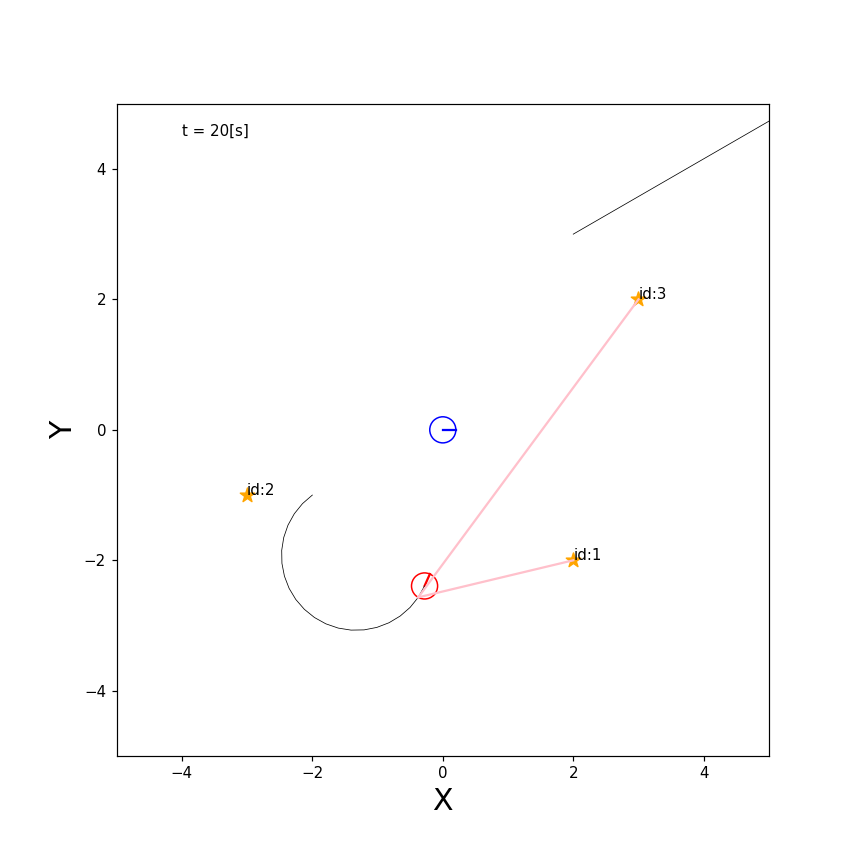

In [64]:
world = World(20, 1, debug=False)                                                                                                                       ### fig:rewrite_robot_for_agent
straight = Agent(0.2, 0.0)                # 0.2[m/s]で直進     
circling = Agent(0.2, 10.0/180*math.pi)   # 0.2[m/s], 10[deg/s]（円を描く）
robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T, sensor=IdealCamera(m), 
                    agent=straight )  
robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, sensor=IdealCamera(m), 
                    agent=circling, color="red")  
robot3 = IdealRobot( np.array([ 0, 0, 0]).T, color="blue")     # エージェントを与えないロボット
world.append(robot1)
world.append(robot2)
world.append(robot3)

m=Map()
m.append_landmark(Landmark(2,-2))
m.append_landmark(Landmark(-3,-1))
m.append_landmark(Landmark(3,2))
world.append(m)

world.draw()

In [41]:
cam=IdealCamera(m)
p = cam.data(robot2.pose)
print(p)

[(array([ 2.22397319, -1.23446367]), 1), (array([3.03462092, 1.40706068]), 2), (array([ 5.29239986, -0.40842962]), 3)]
